In [65]:
import sys, os
sys.path.append(os.path.realpath(".."))

import util_funcs
from importlib import reload
reload(util_funcs)
from copy import deepcopy as cp

import data_reader as read
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import pywt
import tsfresh.feature_extraction.feature_calculators as feats
import constants
import clinical_text_analysis as cta
reload(cta)
import tsfresh
import ensembleReader as er
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, r2_score
from os import path

reload(read)
import wf_analysis.datasets as wfdata
import wf_analysis.filters as filt
reload(filt)
from addict import Dict
import time
import pickle as pkl
import tsfresh.feature_extraction.feature_calculators as tsf
import pyedflib as edf

# Data setup

In [66]:
edss = er.EdfDatasetSegments(pre_cooldown=5, post_cooldown=4, sample_time=4, num_seconds=1, n_process=16)

Starting 16 processes
retrieving: 0
Starting 16 processes
retrieving: 0
retrieving: 1000
retrieving: 2000
retrieving: 3000


In [67]:
train_label_files_segs = edss.get_train_split()

starting custom_annotater
Starting 20 processes
retrieving: 0
retrieving: 1000
retrieving: 2000


In [68]:
test_label_files_segs = edss.get_test_split()

starting custom_annotater
Starting 20 processes
retrieving: 0


In [69]:
mode = er.EdfDatasetSegmentedSampler.DETECT_MODE
reload(er)
train_edss = er.EdfDatasetSegmentedSampler(segment_file_tuples=train_label_files_segs, mode=mode, n_process=8, gap=pd.Timedelta(seconds=1), overlapping_augmentation=True)
train_edss.verbose = False
valid_edss = er.EdfDatasetSegmentedSampler(segment_file_tuples=edss.get_valid_split(), mode=mode, n_process=8, gap=pd.Timedelta(seconds=1), overlapping_augmentation=True)
valid_edss.verbose = False

starting custom_annotater
Starting 20 processes
retrieving: 0


In [70]:
test_edss = er.EdfDatasetSegmentedSampler(segment_file_tuples=test_label_files_segs, mode=mode, n_process=8, gap=pd.Timedelta(seconds=1), overlapping_augmentation=False)
test_edss.verbose = False

In [71]:
train_edss.n_process = 8

In [72]:
train_edss.sampleInfo[114]

{'label': False,
 'token_file_path': '/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/00013182_s001_t000.edf',
 'sample_num': 455.0,
 'sample_width': Timedelta('0 days 00:00:01')}

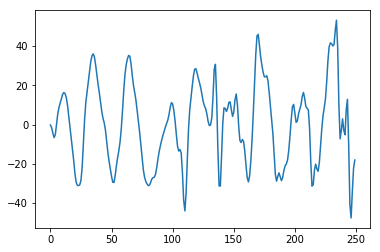

In [73]:
plt.plot(train_edss[113][0].T[0])

In [74]:
# train_edss_scaled = read.EdfStandardScaler(train_edss)
# valid_edss_scaled = read.EdfStandardScaler(valid_edss)

In [75]:
%%bash
ls /home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/
cat /home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/00013182_s001.txt

00013182_s001.txt
00013182_s001_t000.edf
00013182_s001_t000.lbl
00013182_s001_t000.lbl_bi
00013182_s001_t000.tse
00013182_s001_t000.tse_bi
History:	29 year old woman with seizure onset last month.
Medications:	Keppra
Sedation:
EEG Type:	Awake & asleep
Technique:	International 10-20 System; standard 21 electrodes with T1/T2 electrodes and EKG
electrodes, awake, drowsy, asleep, hyperventilation, photic
Description:
Waking background is characterized by a 25-40uV, 9.5Hz alpha rhythm, which attenuates
symmetrically with eye opening.  Symmetric 5-15uV, 18-25Hz activity is present, maximal over
bilateral frontal regions.  During drowsiness, the background slows to central theta activity, frontal
beta activity becomes more prominent, and the alpha rhythm attenuates and becomes intermittent.
During brief stage 2 sleep, the record slows further to moderate voltage 2-4Hz activity, and
symmetric sleep spindles and K complexes appear.
No focal slowing is present.  No epileptiform discharges are pr

In [76]:
from keras_models.dataGen import EdfDataGenerator, RULEdfDataGenerator
import keras_models.dataGen as dg
reload(dg)

<module 'keras_models.dataGen' from '/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py'>

In [77]:
train_edss.use_mp = False
valid_edss.use_mp = False
edg = dg.RULEdfDataGenerator(train_edss, n_classes=2, precache=False, batch_size=16, labels=[train_edss.sampleInfo[key].label for key in train_edss.sampleInfo.keys()])
valid_edg = dg.RULEdfDataGenerator(valid_edss, n_classes=2, precache=False, batch_size=16, labels=[valid_edss.sampleInfo[key].label for key in valid_edss.sampleInfo.keys()])

In [78]:
test_edss.use_mp = False
test_edg = dg.EdfDataGenerator(test_edss, n_classes=2, precache=False, batch_size=32, shuffle=False)
test_labels = [test_edss.sampleInfo[key].label for key in test_edss.sampleInfo.keys()]

In [79]:
seizureLabels = [train_edss.sampleInfo[key].label for key in train_edss.sampleInfo.keys()]

In [29]:
train_edss.sampleInfo

{0: {'label': False,
  'token_file_path': '/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/00013182_s001_t000.edf',
  'sample_num': 774.0,
  'sample_width': Timedelta('0 days 00:00:01')},
 1: {'label': False,
  'token_file_path': '/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/00013182_s001_t000.edf',
  'sample_num': 556.0,
  'sample_width': Timedelta('0 days 00:00:01')},
 2: {'label': False,
  'token_file_path': '/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/00013182_s001_t000.edf',
  'sample_num': 927.0,
  'sample_width': Timedelta('0 days 00:00:01')},
 3: {'label': False,
  'token_file_path': '/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/00013182_s001_t000.edf',
  'sample_num': 525.0,
  'sample_width': Timedelta('0 days 00:00:01')},
 4: {'label': False,
  'token_file_path': '/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/00013182_s001_t000.edf',
  'sample_num': 1058.0,
  'sampl

# Simple NN single Label Approach

In [188]:
from keras_models.cnn_models import conv2d_gridsearch_pre_layers
from keras.layers import Input, Reshape, Dense, TimeDistributed, Dropout
from keras import Model
from keras.optimizers import Adam
pre_layer_h = 16
x = Input((250, 21, 1)) #time, ecg channel, cnn channel
# y = x
y = Reshape((250, 21))(x) #remove channel dim
y = TimeDistributed(Dense(pre_layer_h, activation="relu"))(y)
y = Reshape((250, pre_layer_h, 1))(y) #add back in channel dim
_, y = conv2d_gridsearch_pre_layers(input_shape=(1000,21,1), dropout=0.0, x=y, num_conv_spatial_layers=3, num_spatial_filter=1, num_temporal_filter=2, num_conv_temporal_layers=0, max_pool_stride=(2,2), max_pool_size=(2,2), use_batch_normalization=True)
# y = Dense(30, activation="relu")(y)
y = Dropout(0.25)(y)
y_seizure = Dense(2, activation="softmax", name="seizure")(y)
model = Model(inputs=x, outputs=[y_seizure])


In [189]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 250, 21, 1)        0         
_________________________________________________________________
reshape_44 (Reshape)         (None, 250, 21)           0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 250, 16)           352       
_________________________________________________________________
reshape_45 (Reshape)         (None, 250, 16, 1)        0         
_________________________________________________________________
conv2d_173 (Conv2D)          (None, 250, 16, 1)        10        
_________________________________________________________________
max_pooling2d_145 (MaxPoolin (None, 125, 8, 1)         0         
_________________________________________________________________
dropout_165 (Dropout)        (None, 125, 8, 1)         0         
__________

In [106]:
import pyedflib
reload(pyedflib)
reload(er)
reload(read)

<module 'data_reader' from '/home/ms994/dbmi_eeg_clustering/data_reader.py'>

In [178]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
mc = ModelCheckpoint("/n/scratch2/ms994/single_label.h5", monitor="val_binary_accuracy", save_best_only=True, verbose=True)
stopping = EarlyStopping("val_binary_accuracy", patience=50, verbose=True)

In [97]:
%%bash
ls /home/ms994

Miniconda3-latest-Linux-x86_64.sh
_about.txt
condaenv.7ds8vi6f.requirements.txt
dbmi_eeg_clustering
echo
env.yaml
filelist.out
get_files.sh
google-cloud-sdk
keras-cpu.err
miniconda3
multilabel.h5
nedc_pwd
ngrok
pyedflib
runtime_dir
sacred
secondDbmi
setup_env.sh
startJupyterNotebook.sh
test
test.py
testPredictSeizureData_4.pkl
testSeizureData.pkl
testSeizureData_4.pkl
trainPredictSeizureData_4.pkl
trainSeizureData.pkl
trainSeizureData_4.pkl
train_eeg_lengths.csv
tsfresh
v1.5.0
validPredictSeizureData_4.pkl
validSeizureData.pkl
validSeizureData_4.pkl
watch
~.bashrc


In [ ]:
edg.dataset.use_mp = False
valid_edg.dataset.use_mp = False

model.compile("adam", loss=["binary_crossentropy"], metrics=["binary_accuracy"])
history = model.fit_generator(edg, validation_data=valid_edg, use_multiprocessing=True, max_queue_size=500000, workers=7, epochs=300, callbacks=[stopping])

Epoch 1/300
655/655 [==============================] - 82s 125ms/step - loss: 0.7171 - binary_accuracy: 0.6165 - val_loss: 0.8034 - val_binary_accuracy: 0.4762
Epoch 2/300
655/655 [==============================] - 70s 106ms/step - loss: 0.4016 - binary_accuracy: 0.8366 - val_loss: 1.0948 - val_binary_accuracy: 0.4524
Epoch 3/300
655/655 [==============================] - 76s 116ms/step - loss: 0.2419 - binary_accuracy: 0.9152 - val_loss: 1.0579 - val_binary_accuracy: 0.4365
Epoch 4/300
  1/655 [..............................] - ETA: 14:26 - loss: 0.1884 - binary_accuracy: 0.9375

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.407308). Check your callbacks.
  % delta_t_median)


655/655 [==============================] - 70s 107ms/step - loss: 0.2047 - binary_accuracy: 0.9258 - val_loss: 1.0414 - val_binary_accuracy: 0.4444
Epoch 5/300
655/655 [==============================] - 77s 118ms/step - loss: 0.1732 - binary_accuracy: 0.9385 - val_loss: 0.9842 - val_binary_accuracy: 0.4656
Epoch 6/300
655/655 [==============================] - 72s 110ms/step - loss: 0.1600 - binary_accuracy: 0.9470 - val_loss: 1.0490 - val_binary_accuracy: 0.4550
Epoch 7/300
655/655 [==============================] - 74s 114ms/step - loss: 0.1447 - binary_accuracy: 0.9477 - val_loss: 0.9998 - val_binary_accuracy: 0.4735
Epoch 8/300
655/655 [==============================] - 77s 117ms/step - loss: 0.1397 - binary_accuracy: 0.9508 - val_loss: 0.9488 - val_binary_accuracy: 0.5026
Epoch 9/300
655/655 [==============================] - 71s 108ms/step - loss: 0.1312 - binary_accuracy: 0.9538 - val_loss: 0.9561 - val_binary_accuracy: 0.5476
Epoch 10/300
655/655 [==============================

In [6]:
from keras.models import load_model

In [18]:
model = load_model("/n/scratch2/ms994/single_label.h5")

In [20]:
len(test_edg.dataset)
test_edg.batch_size = 64

In [21]:
predictions = model.predict_generator(test_edg, use_multiprocessing=True, workers=8, max_queue_size=100000)

In [26]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report

In [23]:
accuracy_score(predictions.argmax(1), test_labels)

0.41893136630845845

In [24]:
f1_score(predictions.argmax(1), test_labels)

0.24708656374627633

In [25]:
roc_auc_score(predictions.argmax(1), test_labels)

0.5552546074766065

In [30]:
sum(test_labels)/ len(test_labels)

0.10630920732392257

In [28]:
print(classification_report(predictions.argmax(1), test_labels))

              precision    recall  f1-score   support

           0       0.36      0.97      0.53     44674
           1       0.90      0.14      0.25     88861

    accuracy                           0.42    133535
   macro avg       0.63      0.56      0.39    133535
weighted avg       0.72      0.42      0.34    133535



In [ ]:
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.legend(["train", "validation"])
plt.show()

In [ ]:
valid_edg = dg.EdfDataGenerator(valid_edss, n_classes=2, precache=False, batch_size=16, shuffle=False, labels=[valid_edss.sampleInfo[key].label for key in valid_edss.sampleInfo.keys()])

In [ ]:
prediction = model.predict_generator(valid_edg, use_multiprocessing=True, workers=6, max_queue_size=100000,)

In [ ]:
prediction.sum(0)

In [ ]:
labels = valid_edg.labels

In [ ]:
predictionMax = prediction.argmax(1)

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report

In [ ]:
f1_score(predictionMax, labels)

In [ ]:
roc_auc_score(predictionMax, labels)

In [ ]:
accuracy_score(predictionMax, labels)

In [ ]:
print(classification_report(predictionMax, labels))

In [ ]:
len(labels) / 16

In [ ]:
labels[-5]

In [ ]:
valid_edg[3124][1]

# Try multi label approach?

In [31]:
tkn_file_paths = [train_edss.sampleInfo[key].token_file_path for key in train_edss.sampleInfo.keys()]

In [32]:
patients = [read.parse_edf_token_path_structure(tkn_file_path)[1] for tkn_file_path in tkn_file_paths]

In [33]:
allPatients = list(set(patients + [read.parse_edf_token_path_structure(valid_edss.sampleInfo[key].token_file_path)[1] for key in valid_edss.sampleInfo.keys()]))

In [34]:
patientInd = [allPatients.index(patient) for patient in patients]

In [35]:
validPatientInd = [allPatients.index(read.parse_edf_token_path_structure(valid_edss.sampleInfo[key].token_file_path)[1]) for key in valid_edss.sampleInfo.keys()]

In [36]:
seizureLabels = [train_edss.sampleInfo[key].label for key in train_edss.sampleInfo.keys()]
validSeizureLabels = [valid_edss.sampleInfo[key].label for key in valid_edss.sampleInfo.keys()]

In [37]:
for i in range(len(seizureLabels)):
    train_edss.sampleInfo[i].label = (seizureLabels[i], patientInd[i])

In [38]:
for i in range(len(validSeizureLabels)):
    valid_edss.sampleInfo[i].label = (validSeizureLabels[i], validPatientInd[i])

In [193]:
reload(dg)
edg = dg.RULDataGenMultipleLabels(train_edss, num_labels=2, labels=[seizureLabels, patientInd], xy_tuple_form=False, n_classes=(2, len(allPatients)), use_background_process=True)
valid_edg = dg.RULDataGenMultipleLabels(valid_edss, num_labels=2, labels=[validSeizureLabels, validPatientInd], xy_tuple_form=False, n_classes=(2, len(allPatients)), use_background_process=True)

In [ ]:
edg[100][1][1].argmax(1)

In [ ]:
valid_edg[0][1][1].argmax(1)

In [ ]:
len(valid_edg)

In [ ]:
len(valid_edss) / 16

In [ ]:
len(edg)

## set up nn

In [40]:
from keras_models.cnn_models import conv2d_gridsearch_pre_layers
from keras.layers import Input, Reshape, Dense, TimeDistributed, Dropout
from keras import Model
from keras.optimizers import Adam
pre_layer_h = 512
x = Input((1000, 21, 1)) #time, ecg channel, cnn channel
y = Reshape((1000, 21))(x) #remove channel dim
y = TimeDistributed(Dense(pre_layer_h, activation="relu"))(y)
y = Reshape((1000, pre_layer_h, 1))(y) #add back in channel dim
_, y = conv2d_gridsearch_pre_layers(input_shape=(1000,21,1), dropout=0, x=y, num_conv_spatial_layers=3, num_conv_temporal_layers=3, num_spatial_filter=40, num_temporal_filter=80, max_pool_stride=(2,2), use_batch_normalization=True)
y = Dense(30, activation="relu")(y)
y = Dropout(0.5)(y)
y_seizure = Dense(2, activation="softmax", name="seizure")(y)
y_patient = Dense(len(allPatients), activation="softmax", name="patientId")(y)
model = Model(inputs=x, outputs=[y_seizure, y_patient])


In [41]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000, 21, 1)  0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1000, 21)     0           input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 1000, 512)    11264       reshape_1[0][0]                  
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 1000, 512, 1) 0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
conv2d_1 (

In [42]:
model.compile("adam", loss=["categorical_crossentropy", "categorical_crossentropy"], metrics=["categorical_accuracy"], loss_weights=[1,-1])

In [43]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
mc = ModelCheckpoint("/home/ms994/multilabel.h5", monitor="val_seizure_categorical_accuracy", save_best_only=True, verbose=True)
stopping = EarlyStopping("val_seizure_categorical_accuracy", patience=50, verbose=True)

In [ ]:
valid_batch = valid_edg[0]

In [ ]:
valid_batch

In [ ]:
edg.batch_size= 32

In [44]:
multi_label_history = model.fit_generator(edg, validation_data=valid_edg, use_multiprocessing=True, max_queue_size=500000, workers=7, epochs=100, callbacks=[mc, stopping])

Epoch 1/100
152/152 [==============================] - 176s 1s/step - loss: -13.2937 - seizure_loss: 2.0742 - patientId_loss: 15.3678 - seizure_categorical_accuracy: 0.6660 - patientId_categorical_accuracy: 0.0025 - val_loss: -11.3747 - val_seizure_loss: 1.8646 - val_patientId_loss: 13.2394 - val_seizure_categorical_accuracy: 0.5969 - val_patientId_categorical_accuracy: 0.0258

Epoch 00001: val_seizure_categorical_accuracy improved from -inf to 0.59688, saving model to /home/ms994/multilabel.h5
Epoch 2/100
152/152 [==============================] - 162s 1s/step - loss: -14.7981 - seizure_loss: 1.1160 - patientId_loss: 15.9141 - seizure_categorical_accuracy: 0.7046 - patientId_categorical_accuracy: 6.1679e-04 - val_loss: -13.1635 - val_seizure_loss: 1.2240 - val_patientId_loss: 14.3875 - val_seizure_categorical_accuracy: 0.6181 - val_patientId_categorical_accuracy: 0.0035

Epoch 00002: val_seizure_categorical_accuracy improved from 0.59688 to 0.61806, saving model to /home/ms994/multila

Process ForkPoolWorker-236:
Process ForkPoolWorker-237:
Process ForkPoolWorker-238:
Process ForkPoolWorker-230:
Process ForkPoolWorker-231:
Process ForkPoolWorker-229:
Process ForkPoolWorker-227:
Process ForkPoolWorker-225:
Process ForkPoolWorker-228:
Process ForkPoolWorker-232:
Process ForkPoolWorker-226:
Process ForkPoolWorker-233:
Process ForkPoolWorker-234:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/ker

  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py", line 250, in __getitem__
    X, y = self.__data_generation(list_IDs_temp)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py", line 250, in __getitem__
    X, y = self.__data_generation(list_IDs_temp)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py", line 291, in __data_generation
    x, labels = self.g

  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/internals/construction.py", line 265, in _homogenize
    val = val.reindex(index, copy=False)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/frame.py", line 6487, in apply
    return op.get_result()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/frame.py", line 6487, in apply
    return op.get_result()
KeyboardInterrupt
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/apply.py", line 151, in get_result
    return self.apply_standard()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/apply.py", line 151, in get_result
    return self.apply_standard()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/apply.py", line 257, in apply_standard
    self.apply_series_generator()
  File "/home/ms994/miniconda3/envs/keras

KeyboardInterrupt: 

In [45]:
model = load_model("/home/ms994/multilabel.h5")

In [46]:
predictions = model.predict_generator(test_edg, use_multiprocessing=True, workers=8, max_queue_size=100000)

In [53]:
sum(test_labels)/len(test_labels)

0.10630920732392257

In [56]:
print(classification_report(predictions[0].argmax(1), test_labels))

              precision    recall  f1-score   support

           0       0.28      0.97      0.43     34174
           1       0.92      0.13      0.23     99361

    accuracy                           0.35    133535
   macro avg       0.60      0.55      0.33    133535
weighted avg       0.75      0.35      0.28    133535



In [57]:
accuracy_score(predictions[0].argmax(1), test_labels)

0.34507806942000224

In [58]:
f1_score(predictions[0].argmax(1), test_labels)

0.22985813292003135

In [59]:
sum(predictions[0].argmax(1))

99361

In [60]:
sum(predictions[0].argmax(1))/len(predictions[0].argmax(1))

0.7440820758602613

# Try 3d cnn?

In [15]:
8**3

512

In [32]:
from keras_models.cnn_models import conv2d_gridsearch_pre_layers
from keras.layers import Input, Reshape, Dense, TimeDistributed, Dropout, Conv3D, BatchNormalization, MaxPool3D, Flatten
from keras import Model
from keras.optimizers import Adam
pre_layer_h = 24
x = Input((1000, 21, 1)) #time, ecg channel, cnn channel
y = Reshape((1000, 21))(x) #remove channel dim
y = TimeDistributed(Dense(pre_layer_h**2, activation="relu"))(y)
y = Reshape((1000, pre_layer_h,pre_layer_h, 1))(y) #add back in channel dim


In [33]:
for i in range(2):
    y = BatchNormalization()(y)
    y = Conv3D(10, (3,3,3), activation="relu")(y)
    y = MaxPool3D()(y)

In [34]:
y = Flatten()(y)
y_seizure = Dense(2, activation="softmax", name="seizure")(y)
model = Model(inputs=x, outputs=[y_seizure])

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000, 21, 1)       0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 1000, 21)          0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1000, 576)         12672     
_________________________________________________________________
reshape_6 (Reshape)          (None, 1000, 24, 24, 1)   0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 1000, 24, 24, 1)   4         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 998, 22, 22, 10)   280       
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 499, 11, 11, 10)   0         
__________

In [36]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
mc = ModelCheckpoint("/n/scratch2/ms994/3d_test.h5", monitor="val_binary_accuracy", save_best_only=True, verbose=True)
stopping = EarlyStopping("val_binary_accuracy", patience=50, verbose=True)


In [37]:
from keras.optimizers import Adam

In [38]:
from keras.utils import multi_gpu_model
model = multi_gpu_model(model, 2)
model.compile("adam", loss=["binary_crossentropy"], metrics=["binary_accuracy"])
history = model.fit_generator(edg, validation_data=valid_edg, use_multiprocessing=True, max_queue_size=500000, workers=8, epochs=30, callbacks=[stopping, mc])

Epoch 1/30
310/310 [==============================] - 84s 271ms/step - loss: 4.2705 - binary_accuracy: 0.5790 - val_loss: 8.0151 - val_binary_accuracy: 0.5000

Epoch 00001: val_binary_accuracy improved from -inf to 0.50000, saving model to /n/scratch2/ms994/3d_test.h5


Process ForkPoolWorker-229:
Process ForkPoolWorker-226:
Process ForkPoolWorker-236:
Process ForkPoolWorker-235:
Process ForkPoolWorker-238:
Process ForkPoolWorker-232:
Process ForkPoolWorker-230:
Process ForkPoolWorker-225:
Process ForkPoolWorker-239:
Process ForkPoolWorker-231:
Process ForkPoolWorker-227:
Process ForkPoolWorker-234:
Process ForkPoolWorker-237:
Process ForkPoolWorker-233:
Traceback (most recent call last):
Process ForkPoolWorker-228:
Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, i

  File "/home/ms994/dbmi_eeg_clustering/ensembleReader.py", line 282, in __getitem__
    max_length=self.gap)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py", line 147, in get_x_y
    data = self.dataset[i]
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/keras/utils/data_utils.py", line 401, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/keras/utils/data_utils.py", line 401, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs

  File "/home/ms994/dbmi_eeg_clustering/util_funcs.py", line 91, in getItemSlice
    toReturn[i] = self[j]
KeyboardInterrupt
  File "/home/ms994/dbmi_eeg_clustering/util_funcs.py", line 91, in getItemSlice
    toReturn[i] = self[j]
  File "/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py", line 147, in get_x_y
    data = self.dataset[i]
  File "/home/ms994/dbmi_eeg_clustering/ensembleReader.py", line 274, in __getitem__
    return self.getItemSlice(i)
  File "/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py", line 167, in __getitem__
    X, y = self.__data_generation(list_IDs_temp)
  File "/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py", line 147, in get_x_y
    data = self.dataset[i]
  File "/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py", line 175, in __data_generation
    x, y = self.get_x_y(list_IDs_temp)
  File "/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py", line 175, in __data_generation
    x, y = self.get_x_y(list_IDs_temp)
  File "/ho

  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/reshape/concat.py", line 229, in concat
    return op.get_result()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/apply.py", line 151, in get_result
    return self.apply_standard()


KeyboardInterrupt: 

  File "/home/ms994/dbmi_eeg_clustering/ensembleReader.py", line 296, in __getitem__
    axis=0)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 4455, in get_indexer_for
    return self.get_indexer(target, **kwargs)
  File "/home/ms994/dbmi_eeg_clustering/ensembleReader.py", line 274, in __getitem__
    return self.getItemSlice(i)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/frame.py", line 2867, in _ixs
    label = self.columns[i]
  File "/home/ms994/dbmi_eeg_clustering/ensembleReader.py", line 274, in __getitem__
    return self.getItemSlice(i)
  File "/home/ms994/dbmi_eeg_clustering/data_reader.py", line 638, in edf_eeg_2_df
    periods=len(signal_data)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/apply.py", line 257, in apply_standard
    self.apply_series_generator()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packa

  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/tseries/offsets.py", line 2310, in delta
    return self.n * self._inc
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/series.py", line 3738, in reindex
    return super(Series, self).reindex(index=index, **kwargs)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/internals/construction.py", line 212, in init_dict
    return arrays_to_mgr(arrays, data_names, index, columns, dtype=dtype)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/apply.py", line 286, in apply_series_generator
    results[i] = self.f(v)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/scipy/signal/filter_design.py", line 1105, in zpk2tf
    b = k * poly(z)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/internals/managers.py", line 1666, in create_block_manag

# Try 3d cnn with domain adaptation

In [80]:
tkn_file_paths = [train_edss.sampleInfo[key].token_file_path for key in train_edss.sampleInfo.keys()]

In [81]:
patients = [read.parse_edf_token_path_structure(tkn_file_path)[1] for tkn_file_path in tkn_file_paths]

In [82]:
allPatients = list(set(patients))

In [83]:
patientInd = [allPatients.index(patient) for patient in patients]

In [84]:
# validPatientInd = [allPatients.index(read.parse_edf_token_path_structure(valid_edss.sampleInfo[key].token_file_path)[1]) for key in valid_edss.sampleInfo.keys()]

In [85]:
validPatientInd = [1 for i in valid_edss.sampleInfo.keys()]

In [86]:
seizureLabels = [train_edss.sampleInfo[key].label for key in train_edss.sampleInfo.keys()]
validSeizureLabels = [valid_edss.sampleInfo[key].label for key in valid_edss.sampleInfo.keys()]

In [87]:
for i in range(len(seizureLabels)):
    train_edss.sampleInfo[i].label = (seizureLabels[i], patientInd[i])

In [88]:
for i in range(len(validSeizureLabels)):
    valid_edss.sampleInfo[i].label = (validSeizureLabels[i], validPatientInd[i])
train_edss.use_mp = True
train_edss.n_process = 8
train_edss.verbose = 500
valid_edss.use_mp = True
valid_edss.n_process = 8
valid_edss.verbose = 500

## Set up the data generators

In [89]:
train_edss.use_mp = True
valid_edss.use_mp = True
edg = dg.RULDataGenMultipleLabels(train_edss, num_labels=2, labels=[seizureLabels, patientInd], xy_tuple_form=True, n_classes=(2, len(allPatients)), use_background_process=True, precache=False, batch_size=64)
valid_edg = dg.RULDataGenMultipleLabels(valid_edss, num_labels=2, labels=[validSeizureLabels, validPatientInd], xy_tuple_form=True, n_classes=(2, len(allPatients)), shuffle=False, use_background_process=True, precache=False, batch_size=64)

In [90]:
test_edg = dg.EdfDataGenerator(test_edss)

In [91]:
read.file_list

set()

In [92]:
edg.dataset.n_process = 8
valid_edg.dataset.n_process = 8

In [93]:
edg.precache
train_edss.verbose = True

In [ ]:
edg[0]

## set up 3d nn

In [ ]:
from keras_models.cnn_models import conv2d_gridsearch_pre_layers
from keras.layers import Input, Reshape, Dense, TimeDistributed, Dropout, Conv3D, BatchNormalization, MaxPool3D, Flatten
from keras import Model
from keras.optimizers import Adam
pre_layer_h = 32
x = Input((250, 21, 1)) #time, ecg channel, cnn channel
y = Reshape((250, 21))(x) #remove channel dim
y = TimeDistributed(Dense(pre_layer_h**2, activation="relu"))(y)
y = Reshape((250, pre_layer_h,pre_layer_h, 1))(y) #add back in channel dim


In [ ]:
for i in range(3):
    y = BatchNormalization()(y)
    y = Conv3D(5, (3,3,3), activation="relu")(y)
    y = MaxPool3D()(y)
y = Flatten()(y)


In [ ]:
y_seizure = Dense(2, activation="softmax", name="seizure")(y)
y_patient = Dense(len(allPatients), activation="softmax", name="patient")(y)
model = Model(inputs=x, outputs=[y_seizure, y_patient])

In [ ]:
seizure_model = Model(inputs=x, outputs=[y_seizure])

In [ ]:
model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
mc = ModelCheckpoint("/n/scratch2/ms994/3d_test.h5", monitor="val_binary_accuracy", save_best_only=True, verbose=True)
stopping = EarlyStopping("val_binary_accuracy", patience=50, verbose=True)


In [ ]:
from keras.optimizers import Adam

In [ ]:
from keras.utils import multi_gpu_model
# model = multi_gpu_model(model, 2)
model.compile(Adam(), loss=["binary_crossentropy", "categorical_crossentropy"], loss_weights=[1,-1], metrics=["categorical_accuracy"])
# history = model.fit_generator(edg, validation_data=validEdg, use_multiprocessing=True, max_queue_size=500000, workers=7, epochs=300, callbacks=[stopping, mc])

In [ ]:
patient_model = Model(inputs=x, outputs=[y_patient])
patient_model.compile(Adam(), loss=["binary_crossentropy"], metrics=["categorical_accuracy"])

In [ ]:
layers = patient_model.layers[-1].weights

In [ ]:
model.layers[-1].name

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report

In [ ]:
model.metrics_names, patient_model.metrics_names

## Run the batches

In [ ]:
read.file_list_lock

In [ ]:
read.file_list

In [ ]:
edg.dataset.n_process

In [ ]:
from IPython.display import clear_output
toKeep = ""
num_epochs = 10
training_seizure_accs = []
test_seizure_accs = []
oldPatientWeights = model.layers[-1].get_weights()
oldNonPatientWeights = [layer.get_weights() for layer in model.layers[:-1]]
best_model_acc = -100
for i in range(num_epochs):
    edg.start_background()

    valid_labels = []
    valid_predictions = []

    seizure_accs = []
    patient_accs = []
    for j in range(len(edg)):
        train_batch = edg[j]
        loss, seizure_loss, patient_loss, seizure_acc, patient_acc = model.train_on_batch(train_batch[0], train_batch[1])
        seizure_accs.append(seizure_acc)
        #old patient weights are trying to predict for patient, try to do the prediction!
        model.layers[-1].set_weights(oldPatientWeights)
        #keep the other nonpatient weights which try not to predict for patient!
        oldNonPatientWeights = [layer.get_weights() for layer in model.layers[:-1]]
        patient_loss, patient_acc = patient_model.train_on_batch(train_batch[0], train_batch[1][1])
        patient_accs.append(patient_acc)

        #get weights that try to predict for patient
        oldPatientWeights = patient_model.layers[-1].get_weights()

        #set weights that don't ruin seizure prediction
        for layer_num, layer in enumerate(model.layers[:-1]):
            model.layers[layer_num].set_weights(oldNonPatientWeights[layer_num])
        if (j % 5) == 0:
            clear_output()
            print(toKeep)
            print("epoch: {} batch: {}/{}, seizure acc: {}, patient acc: {}".format(i, j, len(edg), np.mean(seizure_accs), np.mean(patient_accs)))
    valid_edg.start_background()

    for j in range(len(valid_edg)):
        valid_batch = valid_edg[j]
        val_batch_predictions = model.predict_on_batch(valid_batch[0])
        valid_labels.append(valid_batch[1][0].argmax(1))
        valid_predictions.append(val_batch_predictions[0].argmax(1))
    valid_labels = np.hstack(valid_labels)
    val_predictions = np.hstack(valid_predictions)
    try:
        auc = roc_auc_score(val_predictions, valid_labels)
    except Exception:
        auc = "undefined"
    test_acc =  accuracy_score(val_predictions, valid_labels)
    test_seizure_accs.append(test_acc)
    toKeep += ("end epoch: {}, f1: {}, auc: {}, acc: {}\n".format(i, f1_score(val_predictions, valid_labels), auc, test_acc))
    if (test_acc > best_model_acc):
        best_model_acc = test_acc
        try:
            model.save("/n/scratch2/ms994/best_domain_adapt.h5")
            toKeep.append("improved val score from {} to {}".format(best_model_acc, test_acc))
        except Exception as e:
            toKeep.append("{}".format(e))
            toKeep.append("failed saving")
    print(toKeep)

        
    training_seizure_accs.append(np.mean(seizure_accs))
    edg.on_epoch_end()
plt.plot(training_seizure_accs)
plt.plot(test_seizure_accs)
plt.legend(["train", "valid"])
plt.xlabel("num epochs")
plt.ylabel("acc")
plt.show()

In [ ]:
for j in range(len(valid_edg)):
        valid_batch = valid_edg[j]
        val_batch_predictions = model.predict_on_batch(valid_batch[0])
        valid_labels.append(valid_batch[1][0].argmax(1))
        valid_predictions.append(val_batch_predictions[0].argmax(1))
valid_labels = np.hstack(valid_labels)
val_predictions = np.hstack(valid_predictions)
try:
    auc = roc_auc_score(val_predictions, valid_labels)
except Exception:
    auc = "undefined"
test_acc =  accuracy_score(val_predictions, valid_labels)
test_seizure_accs.append(test_acc)
toKeep += ("end epoch: {}, f1: {}, auc: {}, acc: {}\n".format(i, f1_score(val_predictions, valid_labels), auc, test_acc))
print(toKeep)
training_seizure_accs.append(np.mean(seizure_accs))
edg.on_epoch_end()

In [ ]:
model.save("/n/scratch2/ms994/domain_adapt.h5")

In [ ]:
test_edss.use_mp = False
test_edss.n_workers = 1
test_edg = dg.EdfDataGenerator(test_edss, n_classes=2, precache=False, batch_size=32, shuffle=False)
test_labels = [test_edss.sampleInfo[key].label for key in test_edss.sampleInfo.keys()]

In [ ]:
predictions = seizure_model.predict_generator(test_edg, use_multiprocessing=True, workers=16, max_queue_size=100000)

In [ ]:
print(f1_scoreore(predictions.argmax(1), test_labels))

In [ ]:
print(accuracy(predictions.argmax(1), test_labels))

In [ ]:
print(classification_report(predictions.argmax(1), test_labels))

In [ ]:
print(roc_auc_score(predictions.argmax(1), test_labels))

In [ ]:
model.train_on_batch(edg[0][0], edg[0][1])

In [ ]:
layers == patient_model.layers[-1].weights

In [ ]:
patient_model.layers[-1].get_weights()